In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

# download from https://github.com/odashi/small_parallel_enja
x_train, tokenizer_en = load_data('./data/small_parallel_enja/train.en')
y_train, tokenizer_ja = load_data('./data/small_parallel_enja/train.ja')

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.02, random_state=42)

# パディング
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

seqX_len = len(x_train[0])
seqY_len = len(y_train[0])

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM

emb_dim = 256
hid_dim = 256

encoder_inputs = Input(shape=(seqX_len,))
# (seqX_len,)
encoder_embedded = Embedding(en_vocab_size, emb_dim, mask_zero=True)(encoder_inputs)
# (seqX_len, emb_dim)
_, *encoder_states = LSTM(hid_dim, return_state=True)(encoder_embedded)  
# (hid_dim, )

In [32]:
decoder_inputs = Input(shape=(seqY_len,))
# (seqY_len,)
decoder_embedding = Embedding(ja_vocab_size, emb_dim)
decoder_embedded = decoder_embedding(decoder_inputs)
# (seqY_len, emb_dim)
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)
# (seqY_len, hid_dim)
decoder_dense = Dense(ja_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# (seqY_len, ja_vocab_size)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 18, 256)      1699072     input_14[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 18, 256)      2246912     input_15[0][0]                   
__________________________________________________________________________________________________
lstm_5 (LS

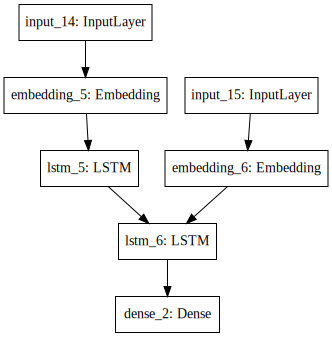

In [34]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [35]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Train on 39200 samples, validate on 9800 samples
Epoch 1/15
39200/39200 [==============================] - 61s 2ms/sample - loss: 2.9791 - val_loss: 2.3208
Epoch 2/15
39200/39200 [==============================] - 68s 2ms/sample - loss: 2.0854 - val_loss: 1.9475
Epoch 3/15
39200/39200 [==============================] - 98s 2ms/sample - loss: 1.8194 - val_loss: 1.7838
Epoch 4/15
39200/39200 [==============================] - 106s 3ms/sample - loss: 1.6552 - val_loss: 1.6562
Epoch 5/15
39200/39200 [==============================] - 136s 3ms/sample - loss: 1.5253 - val_loss: 1.5614
Epoch 6/15
39200/39200 [==============================] - 124s 3ms/sample - loss: 1.4161 - val_loss: 1.4829
Epoch 7/15
39200/39200 [==============================] - 104s 3ms/sample - loss: 1.3221 - val_loss: 1.4237
Epoch 8/15
39200/39200 [==============================] - 134s 3ms/sample - loss: 1.2395 - val_loss: 1.3746
Epoch 9/15
39200/39200 [==============================] - 128s 3ms/sample - loss: 1.1659 -

In [36]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]
decoder_inputs = Input(shape=(1,))
decoder_embedded = decoder_embedding(decoder_inputs)
decoder_outputs, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [37]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])
    output_seq= bos_eos[0][:]
    
    while True:
        output_tokens, *states_value = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

In [38]:
detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

text_no = 0
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join([detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]))
print('正解文:', ' '.join([detokenizer_ja[i] for i in y_test[text_no]]))

元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> あなた は 東京 に 何 を も っ て い い で す か 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>


In [40]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

prediction = ['I', 'am', 'a', 'graduate', 'student', 'at', 'a', 'university']
reference = [['I', 'am', 'a', 'graduate', 'student', 'at', 'the', 'university', 'of', 'tokyo']]

print(sentence_bleu(reference, prediction))

0.5506953149031837


In [41]:
text_no = 1
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

prediction = [detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]
reference = [[detokenizer_ja[i] for i in y_test[text_no]]]

print(prediction)
print(reference)

print(sentence_bleu(reference, prediction))

['<s>', '私', 'は', '学校', 'に', '行', 'き', 'ま', 'す', '。', '</s>']
[['<s>', '私', 'は', '学校', 'で', '勉強', 'する', '。', '</s>']]
0.2790159393585827
